In [11]:
import numpy as np

First, let us define the true values for the gates we aim to construct, so we may compare our results to them later. For any n-controlled gate, this is the same as the 2^(n+1) by 2^(n+1) Identity matrix with the last two rows permuted:

In [2]:
CCX_correct = np.eye(2**3)
CCX_correct[[-1, -2]] = CCX_correct[[-2, -1]]
print(CCX_correct)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [3]:
CCCX_correct = np.eye(2**4)
CCCX_correct[[-1, -2]] = CCCX_correct[[-2, -1]]
print(CCCX_correct)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [4]:
# True n-controlled not gate on n+1th qubit
def CnX_correct(n):
    CnX = np.eye(2**(n+1))
    CnX[[-1, -2]] = CnX[[-2, -1 ]]
    return CnX

Next, we define some useful operators and functions. These include some straightforward tools like the 2x2 identity matrix, CX gate matrix, functions for multiple tensor products, non-adjacent CX gates, and the parameterized unitary given in the task. They also include nontrivial functions which implement a controlled kth-root-pauli X gate, as well as its hermitian conjugate. This implementation is based on the following construction from [1]:

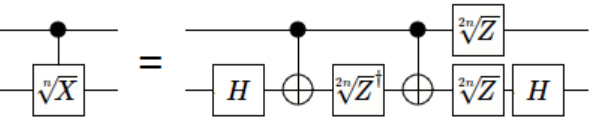


In [5]:
### Useful Operators ###
id = np.eye(2)
cx = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

In [6]:
### Helper Functions ###

# Returns the kronecker product of many operators
def multikron(ops):
    if len(ops) >=3:
        return np.kron(ops[0], multikron(ops[1:]))
    else:
        return np.kron(ops[0], ops[1])

# Arbitrary CNOT matrix (supports nonadjacent qubits)
## c = control, t = target, n = number of qubits
def arb_cx(c, t, n):
    ops0 = [id] * n
    ops0[c-1] = np.array([[1,0],[0,0]])

    ops1 = [id] * n
    ops1[c-1] = np.array([[0,0],[0,1]])
    ops1[t-1] = np.array([[0,1],[1,0]])

    return multikron(ops0) + multikron(ops1)

# Returns parameterized unitary as given in the task
def U(t, p, l):
    return np.array([[np.cos(t/2), -np.exp(1j*l)*np.sin(t/2)],
                     [np.exp(1j*p)*np.sin(t/2), np.exp(1j*(p+l))*np.cos(t/2)]])

# Arbitrary Controlled-kth-root-X (supports nonadjacent qubits), and hermitian conjugate version
def krx(k, c, t, n):
    H = U(np.pi/2, 0, np.pi)
    Zrt = U(0, 0, np.pi/(2*k))
    Zrt_dag = U(0, -np.pi/(2*k) - np.pi, -np.pi)

    ops1 = [id] * n
    ops1[t-1] = H

    ops3 = [id] * n
    ops3[t-1] = Zrt_dag

    ops5 = [id] * n
    ops5[c-1] = Zrt
    ops5[t-1] = H @ Zrt

    return multikron(ops5) @ arb_cx(c,t,n) @ multikron(ops3) @ arb_cx(c,t,n) @ multikron(ops1)

def krx_dag(k, c, t, n):
    H = U(np.pi/2, 0, np.pi)
    Zrt = U(0, 0, np.pi/(2*k))
    Zrt_dag = U(0, -np.pi/(2*k) - np.pi, -np.pi)

    ops1 = [id] * n
    ops1[t-1] = H

    ops3 = [id] * n
    ops3[t-1] = Zrt

    ops5 = [id] * n
    ops5[c-1] = Zrt_dag
    ops5[t-1] = Zrt_dag @ H

    return multikron(ops1) @ arb_cx(c,t,n) @ multikron(ops3) @ arb_cx(c,t,n) @ multikron(ops5)

In [7]:
### CCX ###
timesteps = []

timesteps.append(krx(2,2,3,3))
timesteps.append(arb_cx(1,2,3))
timesteps.append(krx_dag(2,2,3,3))
timesteps.append(arb_cx(1,2,3))
timesteps.append(krx(2,1,3,3))

CCX = np.eye(2**3)
for timestep in timesteps:
    CCX = timestep @ CCX

print(np.linalg.norm(CCX - CCX_correct, ord=2))

1.055376132229156e-15


In [8]:
### CCCX ###
timesteps = []

timesteps.append(krx(4, 1, 4, 4))
timesteps.append(arb_cx(1, 2, 4))
timesteps.append(krx_dag(4, 2, 4, 4))
timesteps.append(arb_cx(1, 2, 4))
timesteps.append(krx(4, 2, 4, 4))
timesteps.append(arb_cx(2, 3, 4))
timesteps.append(krx_dag(4, 3, 4, 4))
timesteps.append(arb_cx(1, 3, 4))
timesteps.append(krx(4, 3, 4, 4))
timesteps.append(arb_cx(2, 3, 4))
timesteps.append(krx_dag(4, 3, 4, 4))
timesteps.append(arb_cx(1, 3, 4))
timesteps.append(krx(4, 3, 4, 4))

CCCX = np.eye(2**4)
for timestep in timesteps:
    CCCX = timestep @ CCCX

print(np.linalg.norm(CCCX - CCCX_correct, ord=2))


2.5075781074669538e-15


In [9]:
### n-controlled kth-root-X gate on jth qubit ###
def CnrX(n, k, j):
    if n >=2 :
        output = np.eye(2**j)
        timesteps = []
        timesteps.append(krx(2*k, n, j, j))
        timesteps.append(multikron([CnrX(n-1, 1, n)] + [id] * (j - n)))
        timesteps.append(krx_dag(2*k, n, j, j))
        timesteps.append(multikron([CnrX(n-1, 1, n)] + [id] * (j - n)))
        timesteps.append(CnrX(n-1, 2*k, j))
        
        for timestep in timesteps:
            output = timestep @ output

        return output
    
    else:
        return krx(k, 1, j, j)

### n-controlled not gate ###
def CnX(n):
    return CnrX(n, 1, n+1)

In [10]:
for n in range(1, 10):
    error = np.linalg.norm(CnX(n) - CnX_correct(n), ord=2)
    print('For an '+str(n)+'-controlled not gate, we have op2-norm error: '+str(error))

For an 1-controlled not gate, we have op2-norm error: 3.6462582309242003e-16
For an 2-controlled not gate, we have op2-norm error: 1.6068590775900611e-15
For an 3-controlled not gate, we have op2-norm error: 4.861154338146604e-15
For an 4-controlled not gate, we have op2-norm error: 1.4458925647940633e-14


For an 5-controlled not gate, we have op2-norm error: 4.316927405939656e-14
For an 6-controlled not gate, we have op2-norm error: 1.2952354382632386e-13
For an 7-controlled not gate, we have op2-norm error: 3.8870678742496605e-13
For an 8-controlled not gate, we have op2-norm error: 1.165283540110665e-12
For an 9-controlled not gate, we have op2-norm error: 3.4972120617108844e-12
